<a href="https://colab.research.google.com/github/Lyshen/PiggyToy/blob/main/Lesson03_CNN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lesson 3. Simple CNN excerise
## 1. Improve lesson 2's code
## 2. Save the usually-used code
## 3. Try to implement your simple CNN using the MNIST dataset
## 4. Compare the results between CNN and DNN
## 5. Maybe it is slow. Try to improve the speed of the SGD


In [1]:
import matplotlib.pyplot as plt
import numpy as np

def plot_features_and_labels(features, labels, size_of_class, markers, colors, title):
    plt.figure(figsize=(3,3))
    for i in range(size_of_class):
        x = features[np.where(labels[:, i] == 1), 0]
        y = features[np.where(labels[:, i] == 1), 1]
        plt.scatter(x, y, marker=markers[i], c=colors[i])
    plt.title(title)
    plt.show()


def split_train_and_test_data(feature_matrix, label_matrix, split_rate = 0.9):
    m = feature_matrix.shape[0]
    split_index = int(m * split_rate)

    indices = np.array(range(m))
    np.random.shuffle(indices)

    train_indices, test_indices = np.array(indices[0:split_index]), np.array(indices[split_index:])
    train_features, train_labels = feature_matrix[train_indices, :], label_matrix[train_indices, :]
    test_features, test_labels = feature_matrix[test_indices, :], label_matrix[test_indices, :]

    return train_features, train_labels, test_features, test_labels


def draw_neuron_boundary(neuron, features, labels, markers, colors, grid_step=0.5, size_of_class= 2):
    min_x, max_x = np.min(features[:, 0]), np.max(features[:, 0])
    min_y, max_y = np.min(features[:, 1]), np.max(features[:, 1])

    xx, yy = np.meshgrid(np.arange(min_x - 1, max_x + 1, grid_step), np.arange(min_y - 1, max_y + 1, grid_step))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    predict = neuron.predict(grid_points)
    argmax_index = np.argmax(predict, axis=1)

    positive_index = grid_points[np.where(argmax_index == 0), :]
    negative_index = grid_points[np.where(argmax_index == 1), :]

    plt.figure(figsize=(4, 4))
    for i in range(size_of_class):
        class_index = grid_points[np.where(argmax_index == i), :]
        plt.scatter(class_index[0, :, 0], class_index[0, :, 1], c=colors[i], alpha=0.1)

    for i in range(size_of_class):
        x = features[np.where(labels[:, i] == 1), 0]
        y = features[np.where(labels[:, i] == 1), 1]
        plt.scatter(x, y, marker=markers[i], c=colors[i])

    plt.show()

#Exercise 1. Do a warm up exercise with double moon dataset
## 1. Design a complex multiple classes classfication problem
## 2. Try to use lesson 2's code
## 3. Improve lesson 2's code


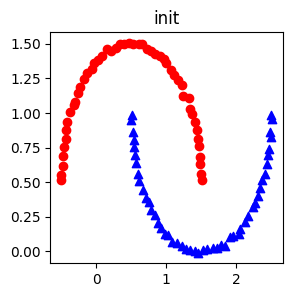

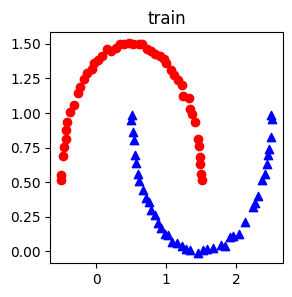

In [2]:
from sklearn.datasets import make_moons, make_circles

time_of_iter = 1
size_of_sample = 100
size_of_features = 2
size_of_class = 2 * time_of_iter

markers = ['o', '^', '*', '>']
colors = ['r', 'b', 'g', 'y']
noises = [0.01, 0.06]
random_indexs = [0.5, 1.7]

feature_list = []
labels = np.zeros((size_of_sample * time_of_iter, size_of_class))

for i in range(time_of_iter):
    moon_features, moon_labels = make_moons(n_samples=size_of_sample, noise=noises[i])
    random_matrix = np.ones(moon_features.shape) * random_indexs[i]
    moon_features = moon_features + random_matrix

    for j in range(2):
        index = i * 2 + j
        matrix_where = i * size_of_sample + np.array(np.where(moon_labels == j))
        labels[matrix_where, index] = 1
    feature_list.append(moon_features)

features = np.concatenate(feature_list, axis=0)
train_features, train_labels, test_features, test_labels = split_train_and_test_data(features, labels)

plot_features_and_labels(features, labels, size_of_class, markers, colors, 'init')
plot_features_and_labels(train_features, train_labels, size_of_class, markers, colors, 'train')
#plot_features_and_labels(test_features, test_labels, size_of_class, markers, colors, 'test')

In [3]:
# Re implement simple DNN
sigmoid = lambda a: 1.0 / (1.0 + np.exp(-a))

# array / vector  very carefully
softmax = lambda a: np.exp(a) / (np.sum(np.exp(a), axis=1)[:, np.newaxis])

class Linear:
    def __init__(self, in_size, out_size = 1):
        self.in_size = in_size + 1
        self.out_size = out_size
        self.X = None
        self.W = np.random.uniform(-1., 1., size=(self.in_size, self.out_size))
        self.dL_by_dW = None

    def forward(self, X):
        self.X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        Z = self.X.dot(self.W)
        return Z

    def backward(self, dL_by_dZ):
        m = dL_by_dZ.shape[0]
        # Matrix Z = XW   X(m, n+1) W(n+1, out) Z(m, out)
        # dL/dZ = (m, out) dZ/dX = W.T  (out, n+1)  dZ/dW = X.T (n+1, m)
        # dL/dW = dZ/dW * dL/dZ  (n+1, out)
        # dL/dX = dL/dZ * dZ/dX  (m, n+1)

        # backward dL/dX and record dL/dW
        dZ_by_dW = self.X.T  #(n+1, m)
        dZ_by_dX = self.W.T  #(out, n+1)
        dL_by_dX = dL_by_dZ.dot(dZ_by_dX) #(m, n+1)
        #dZ/dW = X.T (n+1, m) .dot dL/dZ = (m, out)
        self.dL_by_dW = dZ_by_dW.dot(dL_by_dZ) / m #(n+1, out)
        return dL_by_dX[:, :-1]

    def predict(self, X):
        X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        Z = X.dot(self.W)
        return Z

    def update_weights(self, learning_rate):
        self.W = self.W - self.dL_by_dW * learning_rate


class Sigmoid_Active_Function:
    def __init__(self):
        self.active_function = sigmoid
        self.H = None

    def forward(self, X):
        self.H = self.active_function(X)
        return self.H

    def backward(self, up_gradient):
        self.local_gradient = (1 - self.H) * self.H
        down_gradient = up_gradient * self.local_gradient
        return down_gradient

    def predict(self, X):
        H = self.active_function(X)
        return H

    def update_weights(self, learning_rate):
        return

class Cross_Entropy_Loss:
    def __init__(self):
        self.process_function = softmax

    def forward(self, Z, Y):
        self.Y_hat = self.process_function(Z)
        self.loss = -1. * np.sum(Y * np.log(self.Y_hat, where= self.Y_hat != 0)) #KL divergence
        return self.Y_hat, self.loss

    def backward(self, Y):
        # Math provement
        self.dL_by_dZ = self.Y_hat - Y
        return self.dL_by_dZ

In [4]:
class Operator_Packager:
    def __init__(self, operator_list):
        self.operator_list = operator_list

    def forward(self, X):
        Z = X
        size = len(self.operator_list)
        for i in range(size):
            Z = self.operator_list[i].forward(Z)
        return Z

    def backward(self, E):
        d = E
        size = len(self.operator_list)
        for i in range(size):
            index = size - 1 - i
            d = self.operator_list[index].backward(d)
        return d

    def predict(self, X):
        Z = X
        size = len(self.operator_list)
        for i in range(size):
            Z = self.operator_list[i].predict(Z)
        Y_hat = softmax(Z)
        return Y_hat

    def update_weights(self, learning_rate):
        size = len(self.operator_list)
        for i in range(size):
            self.operator_list[i].update_weights(learning_rate)


In [5]:
class SimpleDNN:
    def __init__(self, size_of_features, size_of_class):
        self.model = Operator_Packager([
            Linear(size_of_features, 3),
            Sigmoid_Active_Function(),
            Linear(3, 3),
            Sigmoid_Active_Function(),
            Linear(3, size_of_class)
        ])

    def forward(self, X):
        Z = self.model.forward(X)
        return Z

    def backward(self, E):
        d = self.model.backward(E)
        return d

    def predict(self, X):
        return self.model.predict(X)

    def update_weights(self, learning_rate):
        self.model.update_weights(learning_rate)


(90, 2)
(90, 2)


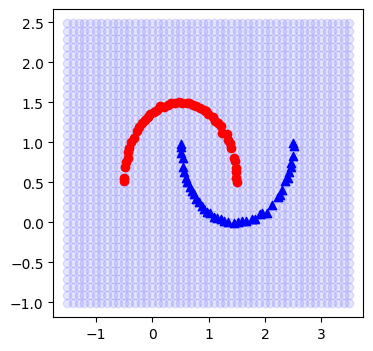

Epoch 1
-------------------------------
loss : 0.334257835282139


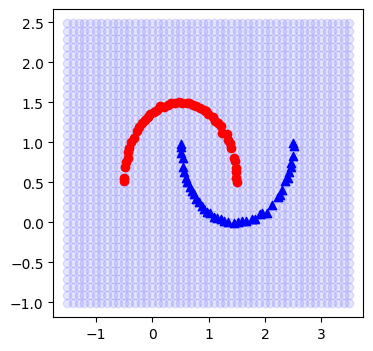

loss : 0.32569912867976364


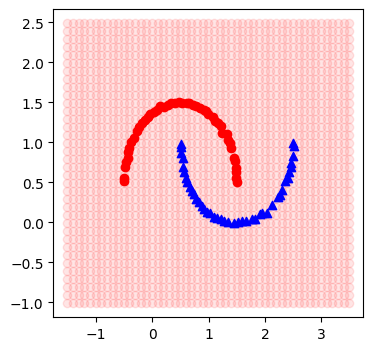

Epoch 21
-------------------------------
loss : 0.024073830137875434


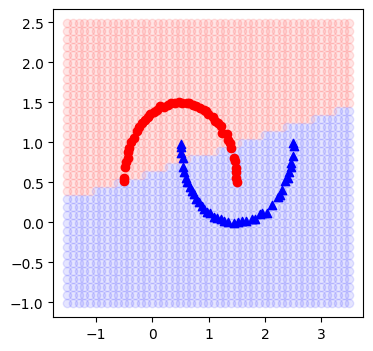

loss : 0.3793434707003883


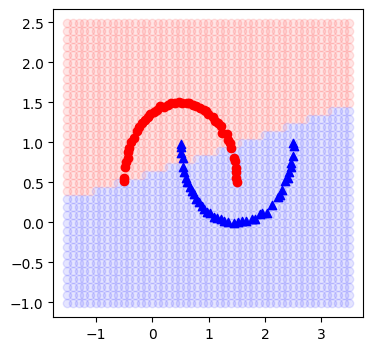

Epoch 41
-------------------------------
loss : 0.004644912652267925


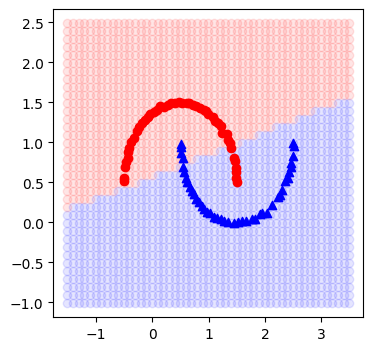

loss : 0.503281918054894


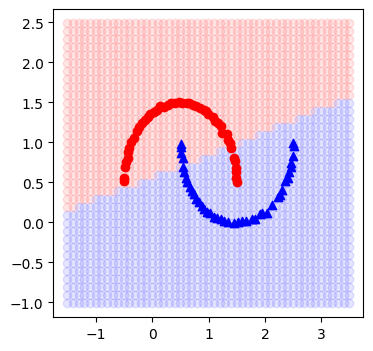

Epoch 61
-------------------------------
loss : 0.0014443188969174498


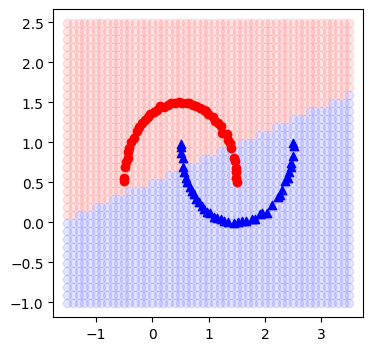

loss : 0.5763794505968626


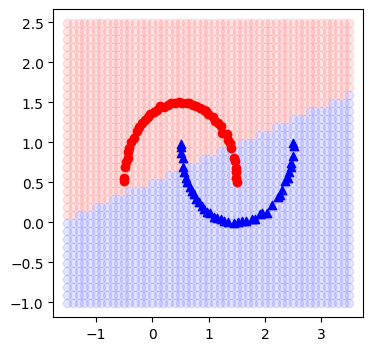

In [6]:
demo_neuron = SimpleDNN(2, 2)
loss = Cross_Entropy_Loss()

print(train_features.shape)
print(train_labels.shape)

draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

epochs = 80
m = train_labels.shape[0]
for t in range(epochs):
    if t % 20 == 0:
        print(f"Epoch {t+1}\n-------------------------------")

    for iter_id in range(m):
        X = train_features[iter_id, :]
        Y = train_labels[iter_id, :]
        X = X.reshape((1, X.shape[0]))
        Y = Y.reshape((1, Y.shape[0]))

        Z = demo_neuron.forward(X)
        predicts, l = loss.forward(Z, Y)

        dL_by_dZ = loss.backward(Y)
        dL_by_dW = demo_neuron.backward(dL_by_dZ)

        demo_neuron.update_weights(learning_rate = 0.3)

        if iter_id % (m-1) == 0 and t % 20 == 0:
            print('loss :', l)
            draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

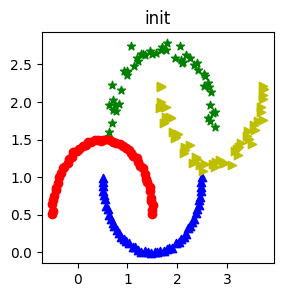

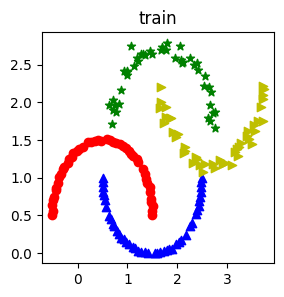

In [7]:
from sklearn.datasets import make_moons, make_circles

time_of_iter = 2
size_of_sample = 100
size_of_features = 2
size_of_class = 2 * time_of_iter

markers = ['o', '^', '*', '>']
colors = ['r', 'b', 'g', 'y']
noises = [0.01, 0.06]
random_indexs = [0.5, 1.7]

feature_list = []
labels = np.zeros((size_of_sample * time_of_iter, size_of_class))

for i in range(time_of_iter):
    moon_features, moon_labels = make_moons(n_samples=size_of_sample, noise=noises[i])
    random_matrix = np.ones(moon_features.shape) * random_indexs[i]
    moon_features = moon_features + random_matrix

    for j in range(2):
        index = i * 2 + j
        matrix_where = i * size_of_sample + np.array(np.where(moon_labels == j))
        labels[matrix_where, index] = 1
    feature_list.append(moon_features)

features = np.concatenate(feature_list, axis=0)
train_features, train_labels, test_features, test_labels = split_train_and_test_data(features, labels)

plot_features_and_labels(features, labels, size_of_class, markers, colors, 'init')
plot_features_and_labels(train_features, train_labels, size_of_class, markers, colors, 'train')

In [8]:
class SimpleDNN:
    def __init__(self, size_of_features, size_of_class):
        self.model = Operator_Packager([
            Linear(size_of_features, 3),
            Sigmoid_Active_Function(),
            Linear(3, 3),
            Sigmoid_Active_Function(),
            Linear(3, size_of_class)
        ])

    def forward(self, X):
        Z = self.model.forward(X)
        return Z

    def backward(self, E):
        d = self.model.backward(E)
        return d

    def predict(self, X):
        return self.model.predict(X)

    def update_weights(self, learning_rate):
        self.model.update_weights(learning_rate)


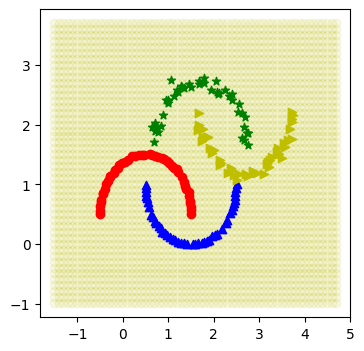

Epoch 1
-------------------------------
loss : 0.8329438357619564


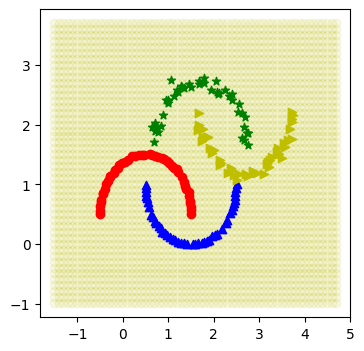

loss : 1.2329466128008508


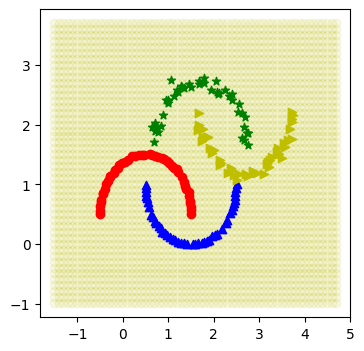

Epoch 11
-------------------------------
loss : 0.1358665583611957


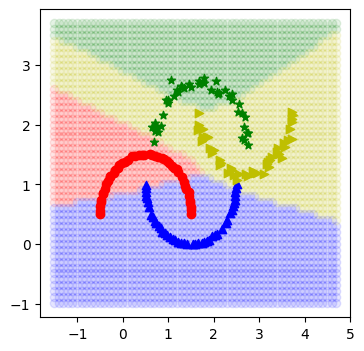

loss : 0.9859871848726993


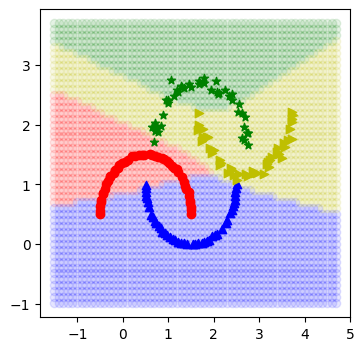

Epoch 21
-------------------------------
loss : 0.13778110936384674


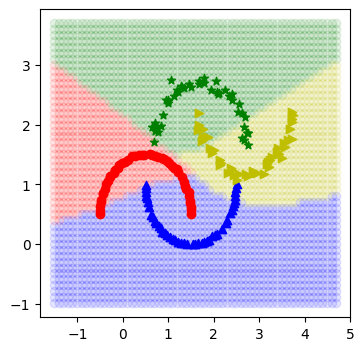

loss : 1.865628871497915


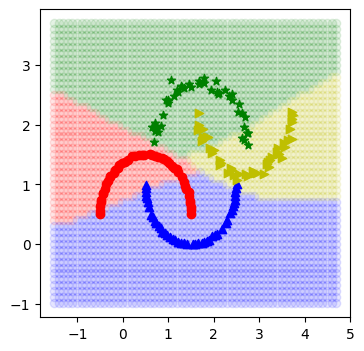

Epoch 31
-------------------------------
loss : 0.10569277616340214


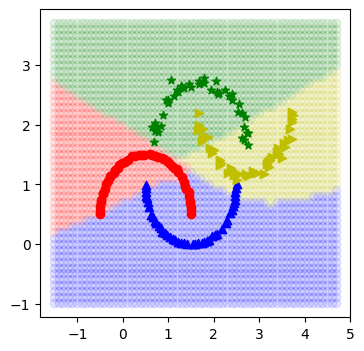

loss : 1.915767734069443


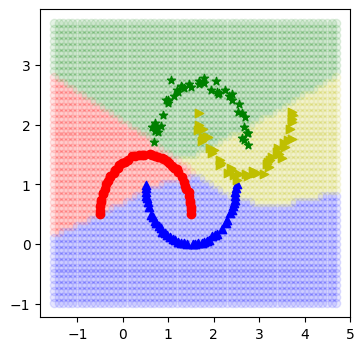

Epoch 41
-------------------------------
loss : 0.14961784440120468


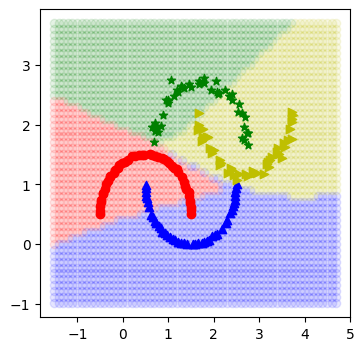

loss : 1.719581754874663


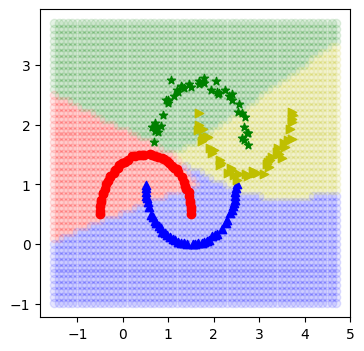

Epoch 51
-------------------------------
loss : 0.11742821752395328


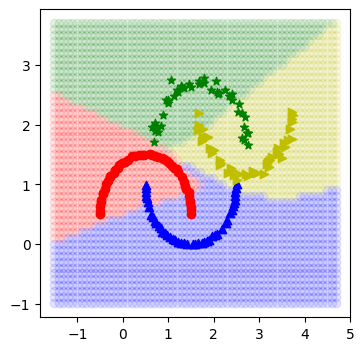

loss : 1.4355469118042217


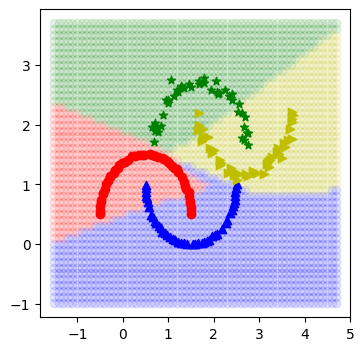

Epoch 61
-------------------------------
loss : 0.1405402029879337


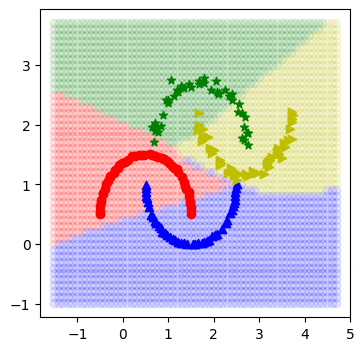

loss : 0.7565757874242087


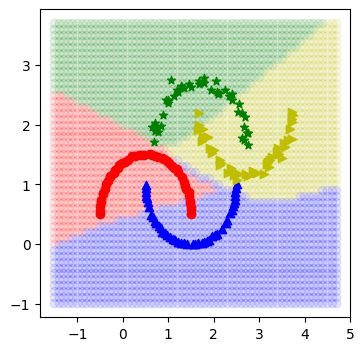

Epoch 71
-------------------------------
loss : 0.20350303759526084


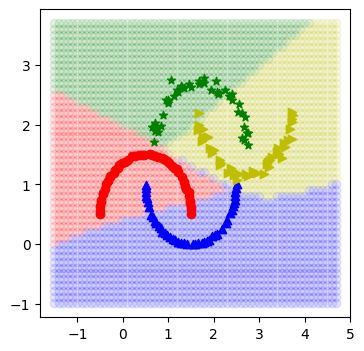

loss : 0.6235952953142859


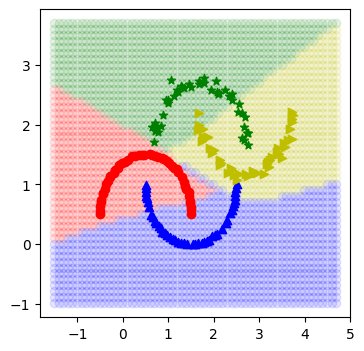

In [9]:
demo_neuron = SimpleDNN(2, 4)
loss = Cross_Entropy_Loss()

draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

epochs = 80
m = train_labels.shape[0]
for t in range(epochs):
    if t % 10 == 0:
        print(f"Epoch {t+1}\n-------------------------------")

    for iter_id in range(m):
        X = train_features[iter_id, :]
        Y = train_labels[iter_id, :]
        X = X.reshape((1, X.shape[0]))
        Y = Y.reshape((1, Y.shape[0]))

        Z = demo_neuron.forward(X)
        predicts, l = loss.forward(Z, Y)

        dL_by_dZ = loss.backward(Y)
        dL_by_dW = demo_neuron.backward(dL_by_dZ)

        demo_neuron.update_weights(learning_rate = 0.3)

        if iter_id % (m-1) == 0 and t % 10 == 0:
            print('loss :', l)
            draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

#Exercise 2. Warm up exercise 2 with double moon dataset
## 1. Try to use a complex DNN to fix a multiple classes classfication problem


In [10]:
class ComplexDNN:
    def __init__(self, size_of_features, size_of_class):
        self.model = Operator_Packager([
            Linear(size_of_features, 10),
            Sigmoid_Active_Function(),
            Linear(10, 10),
            Sigmoid_Active_Function(),
            Linear(10, 10),
            Sigmoid_Active_Function(),
            Linear(10, size_of_class)
        ])

    def forward(self, X):
        Z = self.model.forward(X)
        return Z

    def backward(self, E):
        d = self.model.backward(E)
        return d

    def predict(self, X):
        return self.model.predict(X)

    def update_weights(self, learning_rate):
        self.model.update_weights(learning_rate)

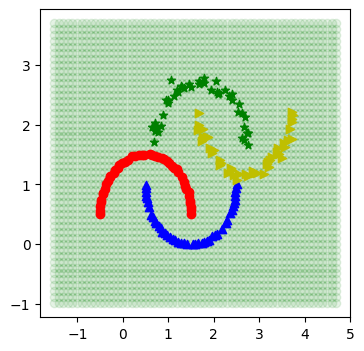

Epoch 1
-------------------------------
loss : 2.673118253512747


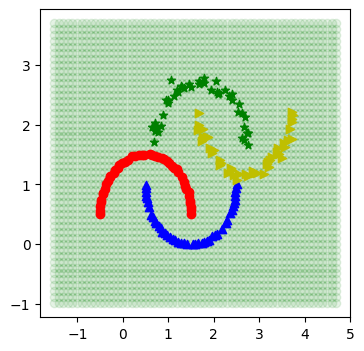

loss : 1.1885692969145876


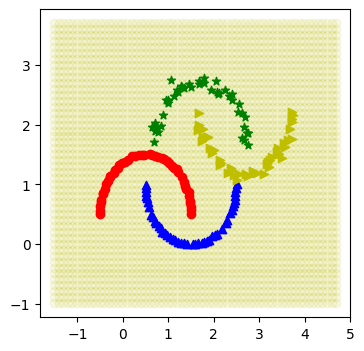

Epoch 51
-------------------------------
loss : 0.054205418684893675


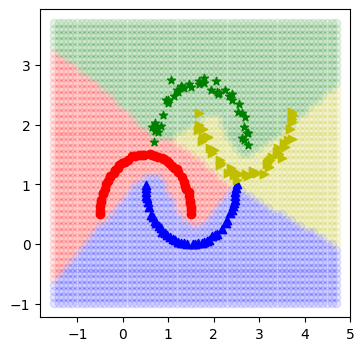

loss : 0.06645208643409131


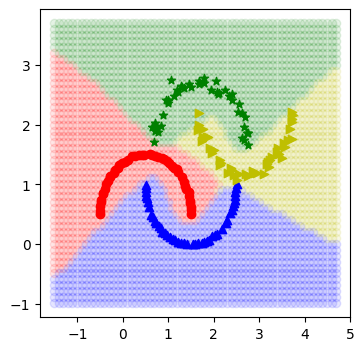

Epoch 101
-------------------------------
loss : 0.01927063994228026


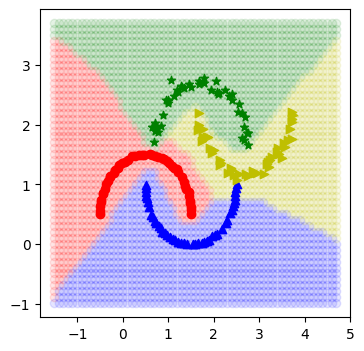

loss : 0.030924012646582715


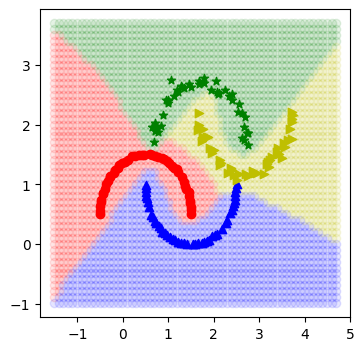

Epoch 151
-------------------------------
loss : 0.011344685305654564


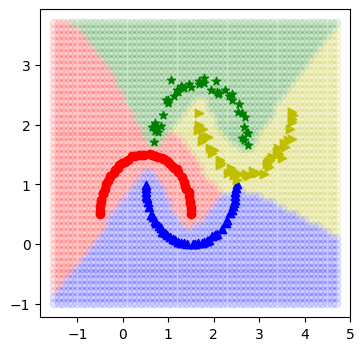

loss : 0.035218661566495384


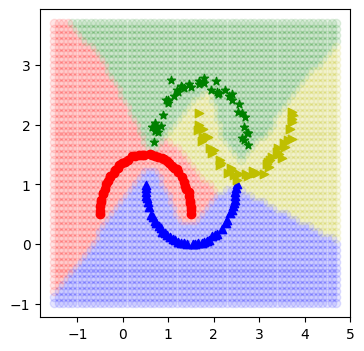

In [12]:
demo_neuron = ComplexDNN(2, 4)
loss = Cross_Entropy_Loss()

draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

epochs = 200
m = train_labels.shape[0]
for t in range(epochs):
    if t % 50 == 0:
        print(f"Epoch {t+1}\n-------------------------------")

    for iter_id in range(m):
        X = train_features[iter_id, :]
        Y = train_labels[iter_id, :]
        X = X.reshape((1, X.shape[0]))
        Y = Y.reshape((1, Y.shape[0]))

        Z = demo_neuron.forward(X)
        predicts, l = loss.forward(Z, Y)

        dL_by_dZ = loss.backward(Y)
        dL_by_dW = demo_neuron.backward(dL_by_dZ)

        demo_neuron.update_weights(learning_rate = 0.3)

        if iter_id % (m-1) == 0 and t % 50 == 0:
            print('loss :', l)
            draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

#Exercise 3: Warm up exercise 3
## 1. A more complicated multiple class classification problem


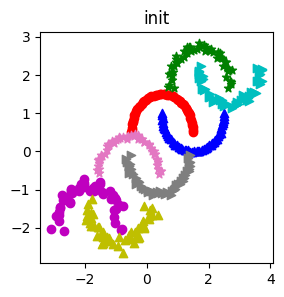

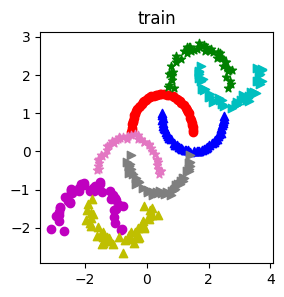

In [13]:
from sklearn.datasets import make_moons, make_circles
import matplotlib.colors as mcolors

time_of_iter = 4
size_of_sample = 100
size_of_features = 2
size_of_class = 2 * time_of_iter
#plot_colortable(mcolors.TABLEAU_COLORS, ncols=2, sort_colors=False)
markers = ['o', '^', '*', '>', 'o', '^', '*', '>', '<' ]
colors = ['r', 'b', 'g', 'c', 'm', 'y', mcolors.TABLEAU_COLORS['tab:pink'], mcolors.TABLEAU_COLORS['tab:gray'], mcolors.TABLEAU_COLORS['tab:olive']]
noises = [0.01, 0.06, 0.1, 0.04]
random_indexs = [0.5, 1.7, -1.9, -0.6]

feature_list = []
labels = np.zeros((size_of_sample * time_of_iter, size_of_class))

for i in range(time_of_iter):
    moon_features, moon_labels = make_moons(n_samples=size_of_sample, noise=noises[i])
    random_matrix = np.ones(moon_features.shape) * random_indexs[i]
    moon_features = moon_features + random_matrix

    for j in range(2):
        index = i * 2 + j
        matrix_where = i * size_of_sample + np.array(np.where(moon_labels == j))
        labels[matrix_where, index] = 1
    feature_list.append(moon_features)

features = np.concatenate(feature_list, axis=0)
train_features, train_labels, test_features, test_labels = split_train_and_test_data(features, labels)

plot_features_and_labels(features, labels, size_of_class, markers, colors, 'init')
plot_features_and_labels(train_features, train_labels, size_of_class, markers, colors, 'train')

In [14]:
class ComplexDNN:
    def __init__(self, size_of_features, size_of_class):
        self.model = Operator_Packager([
            Linear(size_of_features, 20),
            Sigmoid_Active_Function(),
            Linear(20, 20),
            Sigmoid_Active_Function(),
            Linear(20, 20),
            Sigmoid_Active_Function(),
            Linear(20, size_of_class)
        ])

    def forward(self, X):
        Z = self.model.forward(X)
        return Z

    def backward(self, E):
        d = self.model.backward(E)
        return d

    def predict(self, X):
        return self.model.predict(X)

    def update_weights(self, learning_rate):
        self.model.update_weights(learning_rate)

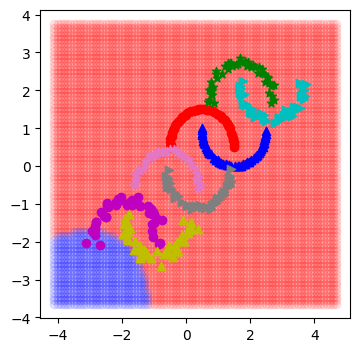

Epoch 1
-------------------------------
loss : 2.932845937336784


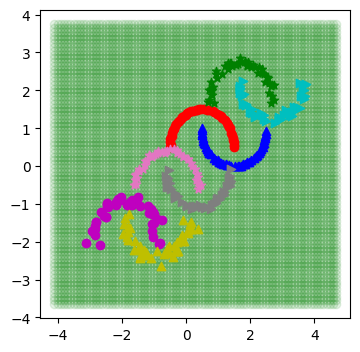

loss : 1.1574876668305616


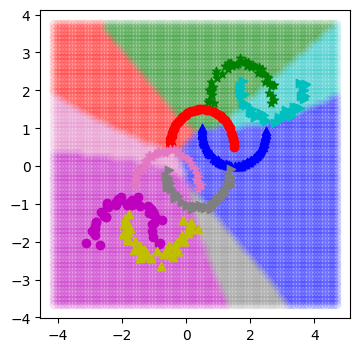

Epoch 101
-------------------------------
loss : 0.4616807356016112


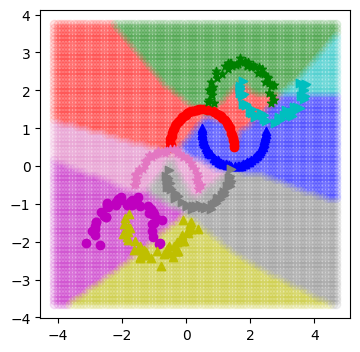

loss : 0.7803049301701885


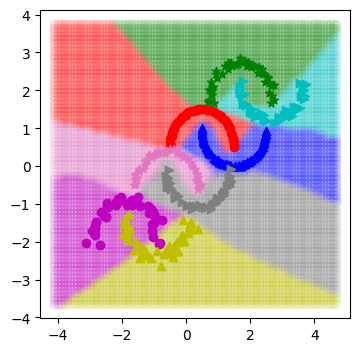

Epoch 201
-------------------------------
loss : 9.120893163282993e-05


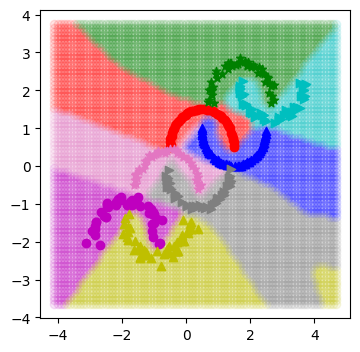

loss : 0.004709053184311612


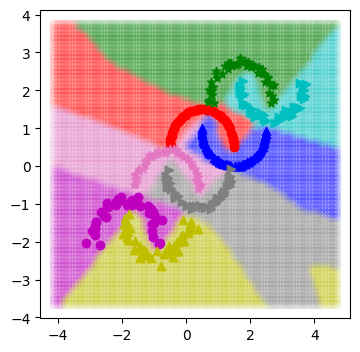

Epoch 301
-------------------------------
loss : 4.3086590330772554e-05


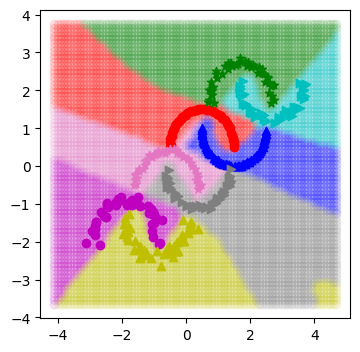

loss : 8.291098334082193e-05


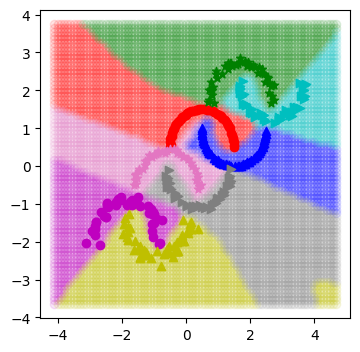

In [16]:
demo_neuron = ComplexDNN(2, 8)
loss = Cross_Entropy_Loss()

draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

epochs = 400
m = train_labels.shape[0]
for t in range(epochs):
    if t % 100 == 0:
        print(f"Epoch {t+1}\n-------------------------------")

    for iter_id in range(m):
        X = train_features[iter_id, :]
        Y = train_labels[iter_id, :]
        X = X.reshape((1, X.shape[0]))
        Y = Y.reshape((1, Y.shape[0]))

        Z = demo_neuron.forward(X)
        predicts, l = loss.forward(Z, Y)

        dL_by_dZ = loss.backward(Y)
        dL_by_dW = demo_neuron.backward(dL_by_dZ)

        demo_neuron.update_weights(learning_rate = 0.3)

        if iter_id % (m-1) == 0 and t % 100 == 0:
            print('loss :', l)
            draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

#Exercise 4: A classical experiment -- MNIST
1. Use your implement of DNN to get a baseline
2. Try to implement your simple CNN model and get the correct bp
3. Use Pytorh CNN model to compare with your own CNN in the effect and speed


In [17]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

In [18]:
tt = transforms.Compose([transforms.ToTensor()])

train_data = MNIST(root='./data', train=True, transform=tt, download=True)
test_data = MNIST(root='./data', train=False, transform=tt)

100%|██████████| 9912422/9912422 [00:00<00:00, 100813064.97it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 10208637.61it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26740794.26it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13784753.09it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



torch.Size([60000, 28, 28])
torch.Size([60000])
torch.Size([10000, 28, 28])
torch.Size([10000])


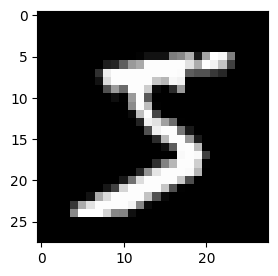

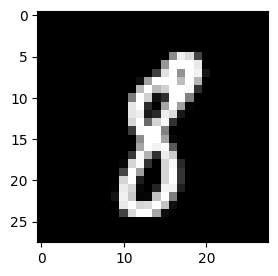

In [19]:
np_train_features = train_data.data.numpy()
np_train_labels = train_data.targets.numpy()

np_test_features = test_data.data.numpy()
np_test_labels = test_data.targets.numpy()

print(train_data.data.shape)
print(train_data.targets.shape)
print(test_data.data.shape)
print(test_data.targets.shape)

#print(train_data.data[0])
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(3, 3))
plt.imshow(np_train_features[0], cmap='gray')
plt.show()
figure = plt.figure(figsize=(3, 3))
plt.imshow(np_train_features[300], cmap='gray')
plt.show()

In [20]:
import numpy as np
train_features = np.resize(np_train_features, (np_train_features.shape[0], 28 * 28))
train_labels = np.zeros((np_train_labels.shape[0], 10))
for i in range(10):
    train_labels[np.where(np_train_labels == i), i] = 1

test_features = np.resize(np_test_features, (np_test_features.shape[0], 28 * 28))
test_labels = np.zeros((np_test_labels.shape[0], 10))
for i in range(10):
    test_labels[np.where(np_test_labels == i), i] = 1

In [21]:
print(train_features.shape)
print(train_labels.shape)
print(train_labels[0])

print(test_features.shape)
print(test_labels.shape)
print(test_labels[0])

(60000, 784)
(60000, 10)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(10000, 784)
(10000, 10)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [24]:
class MnistDNN:
    def __init__(self, size_of_features, size_of_class):
        self.model = Operator_Packager([
            Linear(size_of_features, 50),
            Sigmoid_Active_Function(),
            Linear(50, 50),
            Sigmoid_Active_Function(),
            Linear(50, size_of_class)
        ])

    def forward(self, X):
        Z = self.model.forward(X)
        return Z

    def backward(self, E):
        d = self.model.backward(E)
        return d

    def predict(self, X):
        return self.model.predict(X)

    def update_weights(self, learning_rate):
        self.model.update_weights(learning_rate)

In [25]:
def shuffle_dataset(n, batch_size):
    idices= np.array(range(n))
    np.random.shuffle(idices)
    batch_sample_size = int((n - n % batch_size) / batch_size)
    m = int(batch_size * batch_sample_size)
    a = idices[0:m].reshape((batch_size, batch_sample_size))
    b = idices[m:].reshape((1, n % batch_size))
    return a

shuffle_dataset(100, 4)

array([[94, 55, 76, 21, 91, 25, 29,  9, 88, 69, 71, 42, 68, 75, 10, 34,
        24, 85, 82, 22, 39, 78,  6, 47, 62],
       [38, 77, 18,  8, 92, 13, 81, 97, 11, 30, 74, 86,  4, 36, 60, 65,
        83, 63, 14, 50, 28, 70, 96, 93, 31],
       [95, 19, 79, 56, 46,  2, 80, 73,  5, 89, 90, 12,  7, 53,  3, 87,
        72, 51, 66, 27, 32, 43, 57, 48, 45],
       [17, 84, 26, 35, 40, 99, 37, 54, 59, 33, 41, 58, 67,  1, 20, 23,
         0, 49, 15, 98, 52, 44, 16, 61, 64]])

In [26]:
def get_precision(predict, y):
    a = np.argmax(predict, axis=1)
    b = np.argmax(y, axis=1)

    print(np.sum(a == b) / y.shape[0])

In [28]:
demo_neuron = MnistDNN(28*28, 10)
loss = Cross_Entropy_Loss()

epochs = 200
m = train_labels.shape[0]
for t in range(epochs):
    if t % 10 == 0:
        print(f"Epoch {t+1}\n-------------------------------")

    batch_size = 60
    batch_matrix = shuffle_dataset(m, batch_size)

    l = 0.
    for batch_id in range(batch_size):
        batch_index = batch_matrix[batch_id, :]
        X = train_features[batch_index, :]
        Y = train_labels[batch_index, :]

        Z = demo_neuron.forward(X)
        predicts, l = loss.forward(Z, Y)

        dL_by_dZ = loss.backward(Y)
        dL_by_dW = demo_neuron.backward(dL_by_dZ)

        demo_neuron.update_weights(learning_rate = 0.5)

    if t % 5 == 0:
        predicts = demo_neuron.predict(train_features)
        print('train:')
        get_precision(predicts, train_labels)

        predicts = demo_neuron.predict(test_features)
        print('test:')
        get_precision(predicts, test_labels)

    print('t:', t+1, ' loss :', l)

Epoch 1
-------------------------------


<ipython-input-3-9db4f4321738>:2: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda a: 1.0 / (1.0 + np.exp(-a))


train:
0.5804166666666667
test:
0.5788
t: 1  loss : 1328.9386232424558
t: 2  loss : 935.9186992588166
t: 3  loss : 809.0333566482178
t: 4  loss : 742.0668456224223
t: 5  loss : 659.2856196527634
train:
0.8109166666666666
test:
0.8171
t: 6  loss : 617.5448332376678
t: 7  loss : 599.739654100514
t: 8  loss : 523.6997371276583
t: 9  loss : 507.72203781742706
t: 10  loss : 472.15056511516923
Epoch 11
-------------------------------
train:
0.8468666666666667
test:
0.8517
t: 11  loss : 492.01671173352736
t: 12  loss : 465.2607004140795
t: 13  loss : 512.5478900768271
t: 14  loss : 474.4614290309982
t: 15  loss : 421.4261166949932
train:
0.863
test:
0.8644
t: 16  loss : 442.24307943461247
t: 17  loss : 461.9769069695294
t: 18  loss : 423.0420180866727
t: 19  loss : 416.6103261473073
t: 20  loss : 491.360916681582
Epoch 21
-------------------------------
train:
0.8746333333333334
test:
0.8742
t: 21  loss : 422.8354027485955
t: 22  loss : 399.50405539205303
t: 23  loss : 379.8944464471226
t: 24

In [29]:
#Save the model

model = demo_neuron.model
parameter_list = []
for i in range(len(model.operator_list)):
    if i % 2 == 0:
        print(model.operator_list[i].W.shape)
        np.savetxt('DNN_Mnist_model_%d.txt' % i, model.operator_list[i].W, delimiter=',')

(785, 50)
(51, 50)
(51, 10)


In [31]:
class Convolution:
    def __init__(self, size_of_filter, n):
        self.size_of_filter = size_of_filter
        self.n = n
        self.W = np.random.uniform(-1., 1., size=(self.size_of_filter, self.n, self.n))

    def forward(self, X):
        # dataset = (None, pic_x, pic_y)    Convolution filters = (size_of_filter, n, n)
        # padding function
        return

    def backward(self, E):
        # dE
        return

    def predict(self, X):
        # Only prediction
        return

    def update_weights(self, learning_rate):
        return


class SimpleCNN:
    def __init__(self, size_of_features, size_of_class):
        self.model = Operator_Packager([
            Linear(size_of_features, 50),
            Sigmoid_Active_Function(),
            Linear(50, 50),
            Sigmoid_Active_Function(),
            Linear(50, size_of_class)
        ])

    def forward(self, X):
        Z = self.model.forward(X)
        return Z

    def backward(self, E):
        d = self.model.backward(E)
        return d

    def predict(self, X):
        return self.model.predict(X)

    def update_weights(self, learning_rate):
        self.model.update_weights(learning_rate)